# Description

This code loads in each Climate Model Intercomparison Project 5 (CMIP5) historical+projected global mean temperature data (here, labeled 'TPMN'), determines the central year when each model's 31-year centered-running-mean  timeseries of GMST exceeds 1.07C (relative to the 1850&mdash;1899 IPCC pre-industrial reference period, see [hadcrut_GMST.ipynb](./hadcrut_GMST.ipynb)), and saves out a table with the results into a .csv file, [CMIP5_crossing_year_1.07.csv](./data/analysis/CMIP5_crossing_year_1.07.csv).

# Setup

In [1]:
# import the packages we need to run this code
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
import utilities as util

#### Define attributable temperature anomaly since 1850&mdash;1899 to match observations

In [2]:
# define the attributable warming from the IPCC
deltaC=np.round(1.07,2)

# Load CMIP5 GMST data

CMIP5 data originally downloaded by Karsten Haustein from the [Centre for Environmental Analysis (CEDA)](https://help.ceda.ac.uk/article/4465-cmip5-data) in November 2018. GMST anomalies were calculated relative to the 1850&mdash;1899 IPCC pre-industrial reference period on 23 August 2021.

In [3]:
# define the variable name of GMST in the files
gmst_metric='TPMN'

# Define and get the model file location and names
fLpath='./data/cmip5/30-year_GMST_anom1850-1899/'
# load in the file list
flin=[f for f in os.listdir(fLpath)]
# drop ensemble mean from data we are loading
fl = [i for i in flin if not 'ensmean' in i]
# get the model names and number of models
models=[s[:-74] for s in fl]
nmodel=len(models)
# print the list of climate models in CMIP5
print(np.ravel(models))

['CMCC-CMS' 'CSIRO-Mk3-6-0' 'MPI-ESM-LR' 'MRI-CGCM3' 'MIROC-ESM'
 'bcc-csm1-1-m' 'ACCESS1-0' 'bcc-csm1-1' 'inmcm4' 'NorESM1-M'
 'IPSL-CM5A-MR' 'MIROC-ESM-CHEM' 'IPSL-CM5B-LR' 'MIROC5' 'CMCC-CESM'
 'MPI-ESM-MR' 'GFDL-CM3' 'CCSM4' 'CMCC-CM' 'CESM1-BGC' 'CESM1-CAM5'
 'EC-EARTH' 'CanESM2' 'ACCESS1-3']


### Load Data/Plot for reference

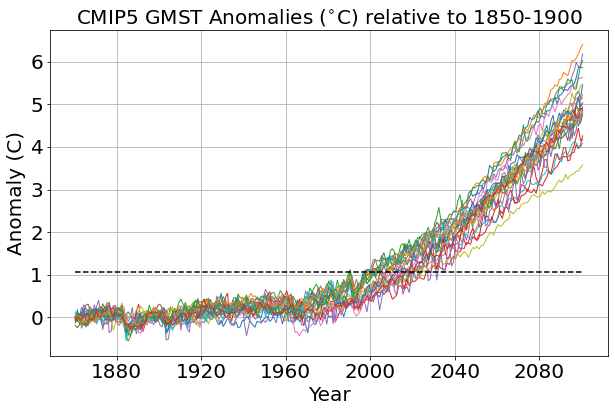

In [4]:
# set up the plot
plt.figure(figsize=(10,6))

# loop over each model to load in the data, organize it, and plot
for i,f in enumerate(fl):
    
    # get this model's path and name
    pathin=fLpath+f
    mname=models[i]
    
    # load this model's data
    dat=xr.open_dataset(pathin)
    
    # remove missing data, set missing equal to NaN
    dat = dat.where(dat[gmst_metric] > -273.15, other=np.nan)
    
    # use datetime64 to convert/define time information
    dat['time']=util.get_dt64(dat)
    
    # plot the timeseries for this model
    plt.plot(dat.time,dat[gmst_metric].values.flatten(),lw=1,label=mname)
    
    # store the data
    
    # if this is the first iteration, initialize
    if i==0:
        
        # initialize time and data storage
        ntime=len(dat['time'])
        gmst_all=np.zeros((nmodel,ntime),dtype='float64')
        gmst_3year=gmst_all.copy()
        
        # find the timegrid for all models
        timegrid=dat.time
        
        # find the model years
        myears=[int(i) for i in timegrid.groupby('time.year').groups.keys()]
        
    # store the GMST for this model
    gmst_all[i,:]=dat[gmst_metric].values.flatten()
    
    # calculate the 3-year running mean, for comparison with HadCRUT later
    gmst_3year[i,:]=dat[gmst_metric].rolling(time=3,center=True).mean().values.flatten()
    
# overplot the attributable warming as a horizontal line
plt.hlines(deltaC,dat.time[0].values,dat.time[-1].values,color='k',ls='--')
    
# plot all of the results together and organize plot labels
plt.title('CMIP5 GMST Anomalies ($^{\circ}$C) relative to 1850-1900',fontsize=20)
plt.ylabel('Anomaly (C)',fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.axis('tight')
plt.grid()
# plt.legend()
plt.show()

### Save out GMST anomalies

Because these will be directly compared with the observed global temperature anomalies, we need to save out the results in the same format. Above, we took the 3-year running (i.e., boxcar-filtered) mean for each model, and now we will save out the results for use in visualizing the comparison in [hadcrut_GMST.ipynb](./hadcrut_GMST.ipynb).

In [5]:
# copy the existing dataset structure
dsave=dat.copy(deep=True)

# delete extra variables and dimensions
dsave=dsave.drop({'lon','lat','time_bnds','TPMN'})

# delete existing attributes
dsave.attrs.clear()

# add variables to the data structure
for i,f in enumerate(fl):
    
    # get the model name for this iteration
    mname=models[i]
    
    # organize the data from this model into an xarray format
    store_model=xr.DataArray(data=gmst_3year[i,:],dims=["time"],
    coords=dict(
        time=dsave.time))
    
    # store the results in the dataset
    dsave[mname]=store_model
    del store_model
    
# define and store the attributes for this dataset
dsave.attrs['description']='3-year centered boxcar mean of individual CMIP5 model global mean near surface temperature anomalies (C) relative to 1850-1899'
dsave.attrs['unit']='Celsius'
dsave.attrs['IPCC_reference_period']='1850-1899'
dsave.attrs['download_date']='November 2018'
dsave.attrs['download_from']='https://help.ceda.ac.uk/article/4465-cmip5-data'


In [6]:
# define the savepath and name
cmip5_savepath='./data/analysis/CMIP5-GMST-3yrmean.nc'

# print what we are about to save
print(dsave)

dsave.to_netcdf(cmip5_savepath)

<xarray.Dataset>
Dimensions:         (time: 241)
Coordinates:
  * time            (time) datetime64[ns] 1860-07-02 1861-07-02 ... 2100-07-02
Data variables: (12/24)
    CMCC-CMS        (time) float64 nan -0.01747 -0.007539 ... 5.231 5.302 nan
    CSIRO-Mk3-6-0   (time) float64 nan -0.04306 0.03071 ... 4.954 5.035 nan
    MPI-ESM-LR      (time) float64 nan -0.05478 -0.08455 ... 4.902 4.883 nan
    MRI-CGCM3       (time) float64 nan 0.03938 0.04787 ... 4.016 4.085 nan
    MIROC-ESM       (time) float64 nan -0.02632 -0.04914 ... 5.921 5.986 nan
    bcc-csm1-1-m    (time) float64 nan -0.1988 -0.1834 ... 4.624 4.645 nan
    ...              ...
    CMCC-CM         (time) float64 nan -0.0329 -0.07668 ... 5.314 5.378 nan
    CESM1-BGC       (time) float64 nan 0.0788 0.03738 ... 4.729 4.788 nan
    CESM1-CAM5      (time) float64 nan -0.01468 0.07213 ... 5.018 5.04 nan
    EC-EARTH        (time) float64 nan 0.001091 -0.02727 ... 4.711 4.773 nan
    CanESM2         (time) float64 nan 0.0323 -0.0

# Find year when each model exceeds attributable warming

Apply a 31-year boxcar filter to smooth out interannual variability before determining the crossing year (i.e., the year when the model crosses the attributable warming threshold defined by the user). This smoothing ensures that models do not trip the exceedance through variability alone, but instead as a result of long-term warming.

In a single model's case, one year of data is missing; this would disrupt our filter analysis. We fill this value with a [simple linear interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html); it has no bearing on that model's exceeding year because it occurs in 1941 well before warming has emerged.

20
CESM1-CAM5
1


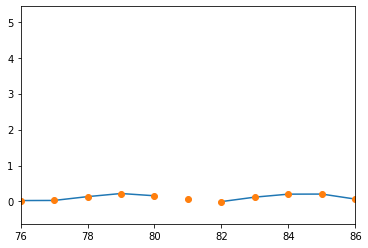

In [7]:
# copy the GMST dataset for each model, for use in filtering
gmst_anom=gmst_all.copy()
# create an array to store the results in
cross_yr=np.zeros((nmodel,),dtype='int')

# loop over each of the models
for i in range(nmodel):
    
    # determine if there are missing values in the array
    if np.sum(np.isnan(gmst_anom[i,:]))>0:
    
        # fill any missing data points with an average in between
        gmst_fill=util.fill_nan(gmst_anom[i,:])
        
        # tell us which model has missing values
        print(i)
        print(models[i])
        print(np.sum(np.isnan(gmst_anom[i,:])))
        
        # can view this result
        fill_loc=np.argwhere(np.isnan(gmst_anom[i,:]))
        plt.plot(gmst_anom[i,:])
        plt.plot(gmst_fill,'o')
        plt.xlim([fill_loc-5,fill_loc+5])

        # store before finding crossing
        gmst_anom[i,:]=gmst_fill
    
    # apply a 31-year centered boxcar filter
    gmst_31year_mean=np.convolve(gmst_anom[i,:], np.ones(31)/31, mode='valid')
    
    # find the year where the 31-year smoothed data crosses the attributable warming threshold
    cross_i=np.argmin(np.abs(gmst_31year_mean-deltaC))+int((np.shape(gmst_anom)[1]-np.shape(gmst_31year_mean)[0])/2)+1
    
    # store the result
    cross_yr[i,]=timegrid[cross_i]['time.year']

### Store the results a dataframe

In [8]:
# sort the models (and their crossing years) by alphabetical order
alphai=np.argsort(models)
alpha_models=np.asarray(models)[alphai]
alpha_cross_yr=cross_yr[alphai]

In [9]:
# store in a pandas array, along with the first and last years in the 31-year bounds
cross_df=pd.DataFrame(np.transpose([alpha_cross_yr,alpha_cross_yr-15,alpha_cross_yr+15]),
                      index=alpha_models,
                      columns=['CrossYear_'+str(np.round(deltaC,2))+'C','FirstYear','LastYear'])
# print the result to screen
print(cross_df)

                CrossYear_1.07C  FirstYear  LastYear
ACCESS1-0                  2014       1999      2029
ACCESS1-3                  2018       2003      2033
CCSM4                      2000       1985      2015
CESM1-BGC                  2003       1988      2018
CESM1-CAM5                 2014       1999      2029
CMCC-CESM                  2025       2010      2040
CMCC-CM                    2017       2002      2032
CMCC-CMS                   2020       2005      2035
CSIRO-Mk3-6-0              2022       2007      2037
CanESM2                    2003       1988      2018
EC-EARTH                   2002       1987      2017
GFDL-CM3                   2013       1998      2028
IPSL-CM5A-MR               2003       1988      2018
IPSL-CM5B-LR               2007       1992      2022
MIROC-ESM                  2010       1995      2025
MIROC-ESM-CHEM             2009       1994      2024
MIROC5                     2018       2003      2033
MPI-ESM-LR                 2003       1988    

# Save out Data in csv format

In [10]:
# define the savepath and name
datsavepath='./data/analysis/'
datsavename='CMIP5_crossing_year_'+str(np.round(deltaC,2))+'C.csv'
# save the result out to a csv file
cross_df.to_csv(datsavepath+datsavename)

# Plot the crossing year data, for reference

In [11]:
# define the edges of the bins that we will plot
bin_edges=np.arange(1990-2.5,2040+1-2.5,5)

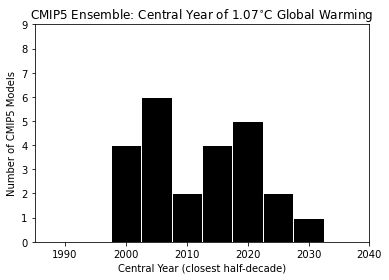

In [12]:
# plot the results
plt.figure()
plt.hist(cross_yr,bins=bin_edges,color='k',edgecolor='white')
plt.title('CMIP5 Ensemble: Central Year of '+str(np.round(deltaC,2))+'$^{\circ}$C Global Warming')
plt.xlabel('Central Year (closest half-decade)')
plt.ylabel('Number of CMIP5 Models')
plt.yticks(np.arange(10))
plt.show()